# Temperatures

We now try to accelerate convergence by scaling up the temperature -- or we'll at least study the effect of such an influence.

In [1]:
import patches
import lettertask
import torch.optim as optim
import torch
import torch.nn as nn
import numpy as np
import plotnine as gg
import lazytools_sflippl as lazytools
import torch.utils as utils
from tqdm import tqdm
import pandas as pd

In [2]:
temperatures = range(0, 1100, 100)
list(temperatures)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [3]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[5, 5],
    change_probability=[0.05, 0.5],
    samples=10000,
    seed=1001
)
cts = patches.data.Contrastive1DTimeSeries(cbm.to_array())
cdl = utils.data.DataLoader(cts, batch_size=8, drop_last=True)
ideal = np.array([1]*5+[0]*5)/np.sqrt(5)

In [4]:
ex_temp = patches.losses.LinearTemperature(5)

In [5]:
ex_temp()

0.0

In [6]:
ex_temp()

0.2

In [7]:
for __ in range(5):
    print(ex_temp())

0.4
0.6
0.8
1
1


In [9]:
loss_dfs = []
angle_dfs = []
with tqdm(total=len(temperatures)*10*10) as pbar:
    for temperature in temperatures:
        for iteration in range(10):
            ce = patches.networks.LinearScaffold(1, data=cts)
            optimizer = optim.Adam(ce.parameters(), lr=0.01)
            criterion = patches.losses.ContrastiveLoss(
                loss=nn.MSELoss(),
                temperature=patches.losses.LinearTemperature(temperature)
            )
            angles = []
            loss_traj = []
            running_loss = 0
            for epoch in range(10):
                running_loss = 0
                for i, data in enumerate(cdl):
                    if i<len(cdl):
                        if i % 10 == 0:
                            est = list(ce.parameters())[0].detach().numpy()
                            angles.append(np.matmul(ideal, est.T)/np.sqrt(np.matmul(est, est.T)))
                        optimizer.zero_grad()
                        code = ce(data)
                        loss = criterion(code)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss
                        if i % 50 == 49:
                            loss_traj.append(running_loss.detach().numpy()/50)
                            running_loss = 0
                pbar.update(1)
            df_angle = lazytools.array_to_dataframe(np.array(angles))\
                                .rename(columns={'dim0': 'steps', 'array': 'angle'})
            df_angle['temperature'] = np.array(temperature)
            df_angle['iteration'] = np.array(iteration)
            df_loss = lazytools.array_to_dataframe(np.array(loss_traj))\
                               .rename(columns={'dim0': 'steps', 'array': 'loss'})
            df_loss['temperature'] = np.array(temperature)
            df_loss['iteration'] = np.array(iteration)
            angle_dfs.append(df_angle)
            loss_dfs.append(df_loss)

100%|██████████| 1100/1100 [59:02<00:00,  3.22s/it]


In [10]:
df_loss = pd.concat(loss_dfs)
df_loss['steps'] += 1
df_loss['group'] = df_loss['temperature'].astype(str) + df_loss['iteration'].astype(str)
df_angle = pd.concat(angle_dfs)
df_angle['steps'] += 1
df_angle['group'] = df_angle['temperature'].astype(str) + df_angle['iteration'].astype(str)

In [17]:
df_loss[np.isnan(df_loss['loss'])].groupby('temperature')['steps'].min()

temperature
200     3
300     3
400     3
500     3
600     3
700     3
800     3
900     3
1000    3
Name: steps, dtype: int64

In [18]:
df_loss = df_loss[df_loss['temperature'] <= 100]
df_angle = df_angle[df_angle['temperature'] <= 100]

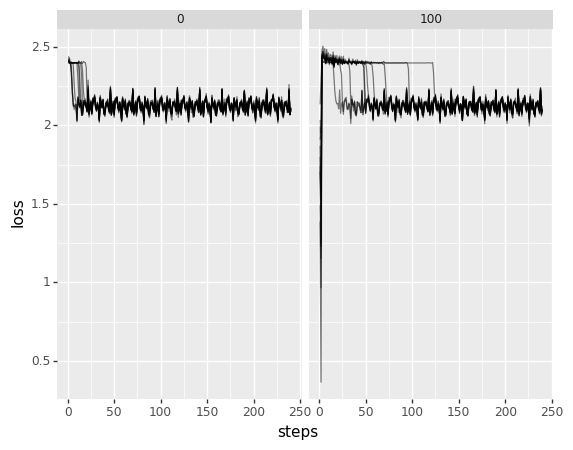

<ggplot: (8762346528292)>

In [19]:
(gg.ggplot(df_loss, gg.aes(x='steps', y='loss', group='iteration')) +
    gg.geom_line(alpha=0.5) +
    gg.facet_wrap('temperature'))

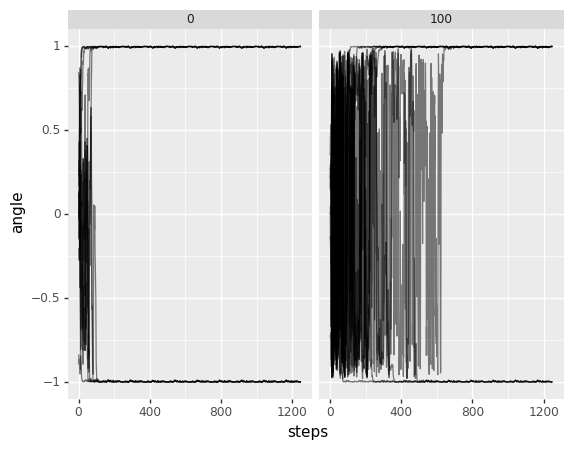

<ggplot: (8762362799855)>

In [20]:
(gg.ggplot(df_angle, gg.aes(x='steps', y='angle', group='iteration')) +
    gg.geom_line(alpha=0.5) +
    gg.facet_wrap('temperature'))

In [22]:
df_angle[abs(df_angle['angle']) >= 0.98].groupby(['iteration', 'temperature'])['steps'].min()

iteration  temperature
0          0               66
           100            208
1          0               21
           100            282
2          0               76
           100            456
3          0               33
           100            358
4          0               18
           100             71
5          0               18
           100            237
6          0              103
           100             71
7          0               82
           100            114
8          0               63
           100            152
9          0               54
           100            241
Name: steps, dtype: int64

This therefore doesn't seem to help and I will return to such explorations at a later point. Possible variations include starting at a minimal threshold, starting at weights above one and decreasing them, and a peroidic weighting function.